In [161]:
# Initial imports
from path import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import psycopg2 as pg

In [162]:
engine = pg.connect("dbname='postgres' user='postgres' host='database-final.cjdbapst3wjf.us-east-1.rds.amazonaws.com' port='5432' password='FinalProject05'")
Contributions = pd.read_sql('select * from merged_2021', con=engine)
Contributions.head()
Contributions.dropna()

,election,candidateid,candidatename,date,contributiontype,city,state,zipcode,amount,matchamt,prevamt,totalamount,expenditure_amount,purposecode,purpose
0,2021,2546,"Andrew,Yang",2021-06-04,Corporation,Glendale,NY,11385,0.0,0.0,0.0,0.0,91,Other,Other: explntion
1,2021,148,"Scott,Stringer",2021-05-01,Limited Liability Company,New York,NY,10006,0.0,0.0,0.0,0.0,3240,Office Rent,Office Rent
2,2021,148,"Scott,Stringer",2021-05-04,Limited Liability Company,New York,NY,10006,0.0,0.0,0.0,0.0,13240,Office Rent,Office Rent
3,2021,148,"Scott,Stringer",2021-06-07,Limited Liability Company,New York,NY,10006,0.0,0.0,0.0,0.0,16762,Office Rent,Office Rent
4,2021,2393,"Maya,Wiley",2021-04-01,Political Action Committee,New York,NY,10036,0.0,0.0,0.0,0.0,1500,Fundraising,Fundraising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10880,2021,2550,"Stacey,Prussman",2021-04-06,Corporation,San Jose,CA,95111,0.0,0.0,0.0,0.0,56,Office Expenses,Office Expenses
10881,2021,2550,"Stacey,Prussman",2021-05-06,Corporation,San Jose,CA,95111,0.0,0.0,0.0,0.0,56,Office Expenses,Office Expenses
10882,2021,2550,"Stacey,Prussman",2021-06-07,Corporation,San Jose,CA,95111,0.0,0.0,0.0,0.0,56,Office Expenses,Office Expenses
10883,2021,2550,"Stacey,Prussman",2021-07-06,Corporation,San Jose,CA,95111,0.0,0.0,0.0,0.0,56,Petition Expenses,Petition Expns.


In [163]:
Contributions_df = Contributions.drop(columns=['election','prevamt'])
total_groupby = Contributions_df.groupby(['candidatename']).sum(['totalamount']).sort_values('totalamount',ascending=False)
Contributions_df['zipcode'] = Contributions_df['zipcode'].apply(str)

In [164]:
Contributions_df = Contributions_df.groupby(['zipcode','date','contributiontype','city','state']).sum('totalamount')

In [165]:
Contributions_df.head()

amount  matchamt  \
zipcode date       contributiontype city             state                     
0       2018-02-05 Other            Brooklyn         NY        0.0       0.0   
        2018-02-22 Other            New York         NY        0.0       0.0   
        2018-12-10 Individual       Brooklyn         NY     2000.0     250.0   
        2019-01-10 Individual       New York         NY      200.0     175.0   
        2019-01-31 Individual       Long Island City NY        0.0       0.0   

                                                            totalamount  \
zipcode date       contributiontype city             state                
0       2018-02-05 Other            Brooklyn         NY             0.0   
        2018-02-22 Other            New York         NY             0.0   
        2018-12-10 Individual       Brooklyn         NY          2250.0   
        2019-01-10 Individual       New York         NY           375.0   
        2019-01-31 Individual       Long Island City NY             0.0   

                                                            expenditure_amount  
zipcode date       contributiontype city             state                      
0       2018-02-05 Other            Brooklyn         NY                    115  
        2018-02-22 Other            New York         NY                     51  
        2018-12-10 Individual       Brooklyn         NY                      0  
        2019-01-10 Individual       New York         NY                      0  
        2019-01-31 Individual       Long Island City NY                      0

In [166]:
Contributions_df = Contributions_df.reset_index()
Contributions_df['contributiontype'].unique()

array(['Other', 'Individual', 'Corporation', 'Limited Liability Company',
       'Political Action Committee', 'Labor Union', 'Candidate Committee',
       'Candidate', 'Party Committee', 'Candidate Family'], dtype=object)

In [167]:
from sklearn.preprocessing import LabelEncoder
Contributions_df_enc = Contributions_df.copy()
le = LabelEncoder()
Contributions_df_enc['date'] = le.fit_transform(Contributions_df['date'])
Contributions_df_enc['contributiontype'] = le.fit_transform(Contributions_df['contributiontype'])
Contributions_df_enc['city'] = le.fit_transform(Contributions_df['city'])
Contributions_df_enc['state'] = le.fit_transform(Contributions_df['state'])
Contributions_df_enc['zipcode'] = le.fit_transform(Contributions_df['zipcode'])
Contributions_df_enc.head()

,zipcode,date,contributiontype,city,state,amount,matchamt,totalamount,expenditure_amount
0,0,18,7,631,36,0.0,0.0,0.0,115
1,0,27,7,3758,36,0.0,0.0,0.0,51
2,0,298,4,631,36,2000.0,250.0,2250.0,0
3,0,327,4,3758,36,200.0,175.0,375.0,0
4,0,344,4,3004,36,0.0,0.0,0.0,0


In [168]:
X = Contributions_df_enc.drop('totalamount',axis = 1)
y = Contributions_df_enc['totalamount']
Contributions_df_enc.nunique()

zipcode               8558
date                  1267
contributiontype        10
city                  6837
state                   55
amount                3417
matchamt              1317
totalamount           5940
expenditure_amount    2142
dtype: int64

In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=79)

In [170]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [171]:
regr = RandomForestRegressor()

In [172]:
regr.fit(X_train, y_train)

RandomForestRegressor()

In [173]:
y_pred = regr.predict(X_test)
print(len(y_pred))

29234


In [174]:
from sklearn.metrics import r2_score
r_squared = r2_score(y_test, y_pred)

0.8568191500818286


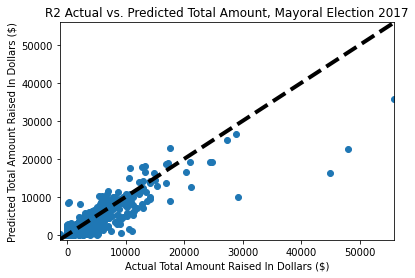

In [175]:
print(r_squared)
plt.scatter(y_test,y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual Total Amount Raised In Dollars ($)')
plt.ylabel('Predicted Total Amount Raised In Dollars ($)')
plt.title('R2 Actual vs. Predicted Total Amount, Mayoral Election 2017')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.savefig('../Resources/Predicted_Total_Amount_Regression_2021.png')

In [176]:
pred_df = X_test
pred_df['Predicted Total Amount'] = y_pred

/Users/Abir/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [177]:
# pred_df.isnull().sum()

In [178]:
# pred_graph = pred_df.groupby('zipcode').sum('redicted Total Amount').sort_values(by=['Predicted Total Amount'],ascending=True)

In [179]:
# pred_graph = pred_graph.reset_index()
# pred_graph